# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# Restart kernel after installation 

#!pip install --user scikit-learn --upgrade

#!pip install --user --upgrade seaborn

#sns.__version__

#sklearn.__version__

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import workspace_utils
from workspace_utils import active_session
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score
import warnings
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import random
import re
from sklearn.cluster import KMeans
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
random.seed(42)
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 20)
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 1a: Load Data

Because of the need to select certain features from the data, based on information provided about the data on the information spreadsheet, the features in the list below where selected from the data for both customer and general population data. A total of 86 features were selected. This list is then used to load only the selected feature.

In [3]:
features2keep_list = ['AGER_TYP','ALTERSKATEGORIE_GROB','ALTER_HH','ANREDE_KZ','ANZ_HAUSHALTE_AKTIV',
'ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','ARBEIT','BALLRAUM','CAMEO_DEUG_2015','CAMEO_DEU_2015',
'CAMEO_INTL_2015','CJT_GESAMTTYP','EWDICHTE','FINANZTYP','FINANZ_ANLEGER',
'FINANZ_HAUSBAUER','FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_UNAUFFAELLIGER',
'FINANZ_VORSORGER','GEBAEUDETYP','GEBAEUDETYP_RASTER','GEBURTSJAHR','GFK_URLAUBERTYP',
'GREEN_AVANTGARDE','HEALTH_TYP','HH_EINKOMMEN_SCORE','INNENSTADT','KBA05_ANTG1',
'KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','KBA05_BAUMAX','KBA05_GBZ','KBA13_ANZAHL_PKW',
'KBA13_AUTOQUOTE','KBA13_TOYOTA','KK_KUNDENTYP','KKK','KONSUMNAEHE','LP_FAMILIE_FEIN','LP_FAMILIE_GROB',
'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB',
'MIN_GEBAEUDEJAHR','MOBI_REGIO','NATIONALITAET_KZ','ONLINE_AFFINITAET','ORTSGR_KLS9',
'OST_WEST_KZ','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_BAUMAX',
'PLZ8_GBZ','PLZ8_HHZ','PRAEGENDE_JUGENDJAHRE','REGIOTYP','RELAT_AB','RETOURTYP_BK_S',
'SEMIO_DOM','SEMIO_ERL','SEMIO_FAM','SEMIO_KAEM','SEMIO_KRIT','SEMIO_KULT','SEMIO_LUST',
'SEMIO_MAT','SEMIO_PFLICHT','SEMIO_RAT','SEMIO_REL','SEMIO_SOZ','SEMIO_TRADV',
'SEMIO_VERT','SHOPPER_TYP','TITEL_KZ','VERS_TYP','WOHNDAUER_2008','WOHNLAGE',
'W_KEIT_KIND_HH','ZABEOTYP']

In [4]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv',usecols=features2keep_list, sep=';')

In [5]:
# check the structure of the customer data
print('The general population data has {} rows and {} columns.\n'.format(azdias.shape[0],azdias.shape[1]))

The general population data has 891221 rows and 86 columns.



In [6]:
# Create a new dataframe using azdias
general_data = azdias

In [7]:
# load in the data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv',usecols=features2keep_list,sep=';')

In [8]:
#check the structure of the customer data
print('The customer population data has {} rows and {} columns.\n'.format(customers.shape[0],customers.shape[1]))

The customer population data has 191652 rows and 86 columns.



## Part 1b: Explore Data

The general dataset contain negative values, NaNs, encoded missing or unknown values provided in the information spreadsheet and object data type columns. Ploting the existing NaNs in the data showed the presence of outlier NaN values count columns in the dataset. The data preparation can cleaning steps below would focus on the aforementioned conditions of the general dataset.

In [9]:
# Describe general data
general_data.describe()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,EWDICHTE,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,891221.000000,817722.000000,798073.000000,794213.000000,817722.000000,817722.000000,794005.000000,797481.000000,886367.000000,797481.000000,...,891221.000000,891221.000000,817722.000000,891221.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,-0.358435,10.864126,8.287263,0.040647,1.727637,0.004162,3.167854,4.153043,3.632838,3.939172,...,4.023709,1.266967,0.003483,1.197852,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,1.198724,7.639683,15.628087,0.324028,1.155849,0.068855,1.002376,2.183710,1.595021,1.718996,...,2.077746,1.287435,0.084957,0.952532,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,-1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,2.000000,2.000000,...,2.000000,0.000000,0.000000,1.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,-1.000000,13.000000,4.000000,0.000000,1.000000,0.000000,3.000000,5.000000,4.000000,4.000000,...,4.000000,1.000000,0.000000,1.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,-1.000000,17.000000,9.000000,0.000000,2.000000,0.000000,4.000000,6.000000,5.000000,6.000000,...,6.000000,2.000000,0.000000,2.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,3.000000,21.000000,595.000000,23.000000,45.000000,6.000000,9.000000,7.000000,6.000000,6.000000,...,7.000000,3.000000,5.000000,2.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [10]:
# Null data already pre-exists in the data
general_data.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,-1,NaN,-1,NaN,NaN,NaN,3,1,2
1,-1,0.0,11.0,0.0,2.0,0.0,3.0,6.0,8A,8,...,1,3,0.0,2,3.0,9.0,4.0,5,2,1
2,-1,17.0,10.0,0.0,1.0,0.0,3.0,2.0,4C,4,...,4,2,0.0,1,3.0,9.0,2.0,5,2,3
3,2,13.0,1.0,0.0,0.0,0.0,2.0,4.0,2A,2,...,4,1,0.0,1,NaN,9.0,7.0,3,2,4
4,-1,20.0,3.0,0.0,4.0,0.0,4.0,2.0,6B,6,...,7,2,0.0,2,2.0,9.0,3.0,4,1,3


In [11]:
# check the data type of each column of the general_data, shows there are int64, float64 and object data type features.

general_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 86 columns):
AGER_TYP                 891221 non-null int64
ALTER_HH                 817722 non-null float64
ANZ_HAUSHALTE_AKTIV      798073 non-null float64
ANZ_HH_TITEL             794213 non-null float64
ANZ_PERSONEN             817722 non-null float64
ANZ_TITEL                817722 non-null float64
ARBEIT                   794005 non-null float64
BALLRAUM                 797481 non-null float64
CAMEO_DEU_2015           792242 non-null object
CAMEO_DEUG_2015          792242 non-null object
CAMEO_INTL_2015          792242 non-null object
CJT_GESAMTTYP            886367 non-null float64
EWDICHTE                 797481 non-null float64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_VORSORGER      

In [12]:
# View total number of NaNs already existing in the general_data by column

general_data.isnull().sum()

AGER_TYP                     0
ALTER_HH                 73499
ANZ_HAUSHALTE_AKTIV      93148
ANZ_HH_TITEL             97008
ANZ_PERSONEN             73499
ANZ_TITEL                73499
ARBEIT                   97216
BALLRAUM                 93740
CAMEO_DEU_2015           98979
CAMEO_DEUG_2015          98979
                         ...  
SEMIO_VERT                   0
SHOPPER_TYP                  0
TITEL_KZ                 73499
VERS_TYP                     0
W_KEIT_KIND_HH          107602
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 86, dtype: int64

<AxesSubplot:>

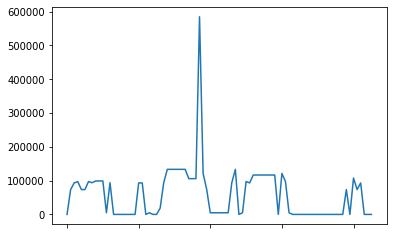

In [13]:
general_data.isnull().sum().plot()

## Part 1c: Prepare Data

Based on the information about the data values provided in the attributes spreadsheet, different values are used to encode missing value for the attributes in the data. Hence, an additional spreadsheet containing attributes and its missing or unknown values encoding was created and named features_unknow_or_missing_values.csv. This additional csv has been read in below.

In [14]:
# load in a feature and missing or unknown value csv created using
# provided DIAS Attributes - Values 2017.xlsx
feature_unknown_or_missing = pd.read_csv('./feature_unknown_or_missing_values.csv', sep=',')

feature_unknown_or_missing.head()

,Attribute,type,missing_or_unknown
0,AGER_TYP,categorical,[-1]
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0,9]"
2,ALTER_HH,interval,[0]
3,ANREDE_KZ,categorical,"[-1, 0]"
4,ANZ_HAUSHALTE_AKTIV,numeric,[]


### Prepare Data - Step 1: Convert missing or unknown values to Numpy NaN

The strategy here is to create a dictionary of unknown or missing values of attributes. The dictionary key is the attribute and the value is a list if the values used to encode unknown or missing values. The key value mapping is used below to encode the missing or unknown values as numpy NaN. Notice that the dictionary is first used to check the expected outcome of the NaN application with the function count_encoded_unknown and finally the conversion to numpy NaN using the function apply_NaN_values.

In [15]:
# Create a dictionary of unknown_or_missing values list. This would be used to convert the missing values to numpy NaN.

feature_unknown_with_val = feature_unknown_or_missing.loc[~feature_unknown_or_missing['missing_or_unknown'].isin(['[-1,X]','[XX]','[-1,XX]'])]

mix_feature_unknown_with_val = feature_unknown_or_missing.loc[feature_unknown_or_missing['missing_or_unknown'].isin(['[-1,X]','[XX]','[-1,XX]'])]


# Create an empty list to hold the values list of missing values
unknown_or_missing = []

mix_unknown_or_missing = []

# Create a list of unknown or missing values
unknown_or_missing_list = list(feature_unknown_with_val['missing_or_unknown'])
mix_unknown_or_missing_list = list(mix_feature_unknown_with_val['missing_or_unknown'])

# Regex for negative unknow or missing values
negative_regex = re.compile('-?\d+')

# Regex for mixed value list items
mix_regex = re.compile('XX|X|-?\d+')

# Create list of numberical values from unknown list values array  
for item in unknown_or_missing_list:
    unknown_num_list = list(map(int,negative_regex.findall(item)))
    unknown_or_missing.append(unknown_num_list)
    
# Create list of mixed values from mixed list values array
for item in mix_unknown_or_missing_list:
    mix_unknown_num_list = list(mix_regex.findall(item))
    mix_unknown_or_missing.append(mix_unknown_num_list)

unknown_or_missing_dict = dict(zip(feature_unknown_or_missing['Attribute'].values.tolist(),unknown_or_missing))


mix_unknown_or_missing_dict = dict(zip(mix_feature_unknown_with_val['Attribute'].values.tolist(),mix_unknown_or_missing))

unknown_dict = {**unknown_or_missing_dict, **mix_unknown_or_missing_dict}

print(unknown_dict)


{'AGER_TYP': [-1], 'ALTERSKATEGORIE_GROB': [-1, 0, 9], 'ALTER_HH': [0], 'ANREDE_KZ': [-1, 0], 'ANZ_HAUSHALTE_AKTIV': [], 'ANZ_HH_TITEL': [], 'ANZ_PERSONEN': [], 'ANZ_TITEL': [], 'ARBEIT': [], 'BALLRAUM': [-1], 'CAMEO_DEUG_2015': ['-1', 'X'], 'CAMEO_DEU_2015': ['XX'], 'CAMEO_INTL_2015': ['-1', 'XX'], 'CJT_GESAMTTYP': [-1], 'EWDICHTE': [-1], 'FINANZTYP': [-1], 'FINANZ_ANLEGER': [-1], 'FINANZ_HAUSBAUER': [-1], 'FINANZ_MINIMALIST': [-1], 'FINANZ_SPARER': [-1, 0], 'FINANZ_UNAUFFAELLIGER': [0], 'FINANZ_VORSORGER': [], 'GEBAEUDETYP': [], 'GEBAEUDETYP_RASTER': [], 'GEBURTSJAHR': [-1], 'GFK_URLAUBERTYP': [-1, 0], 'GREEN_AVANTGARDE': [-1], 'HEALTH_TYP': [-1], 'HH_EINKOMMEN_SCORE': [-1], 'INNENSTADT': [-1], 'KBA05_ANTG1': [-1], 'KBA05_ANTG2': [-1, 0], 'KBA05_ANTG3': [-1, 0], 'KBA05_ANTG4': [], 'KBA05_BAUMAX': [-1], 'KBA05_GBZ': [-1], 'KBA13_ANZAHL_PKW': [], 'KBA13_AUTOQUOTE': [-1, 0], 'KBA13_TOYOTA': [], 'KK_KUNDENTYP': [], 'KKK': [], 'KONSUMNAEHE': [], 'LP_FAMILIE_FEIN': [], 'LP_FAMILIE_GROB': [

In [16]:
# Count the number of missing/unknown values per attribute based on encoded null missing values 
# in the feature summary dataset.

# Count of NaN for features in the encoded features list function 
def count_encoded_unknown(df,v_dict):
    """count the default pre-existing NaN
    and the NaN encoded values for each 
    feature. Intended to verify the final 
    apply_NAN_values function below
    
    INPUT:
    Dataframe and a dictionary
    of features and the corresponding
    missing/unknown values encoding list
    
    OUTPUT:
    Dataframe of count of the expected
    numpy NaN count for each feature after 
    number NaN is applied.
    """
    unknown_df_temp = []
    for key,value in v_dict.items():
        count_prexisting_nan = df[key].isnull().sum()
        count_values_unknown = len(df.loc[df[key].isin(value)])
        sum_unknown = count_prexisting_nan + count_values_unknown
        unknown_df_temp.append([key,count_prexisting_nan,count_values_unknown,sum_unknown])
        unknown_count_df = pd.DataFrame(unknown_df_temp,columns=['Feature','Count_pre_exisiting_nan','Count_encoded_nan','Expected_total_count_of_nan'])
    return(unknown_count_df)

In [17]:
# Table showing Count of NaN from pre-existing null records, count of NaN from encodings in feature summary 
# and the expected total count of NaN for the row after encoding is changed to numpy NaN

expected_nan_records_count = count_encoded_unknown(general_data,unknown_dict)

expected_nan_records_count

,Feature,Count_pre_exisiting_nan,Count_encoded_nan,Expected_total_count_of_nan
0,AGER_TYP,0,677503,677503
1,ALTERSKATEGORIE_GROB,0,2881,2881
2,ALTER_HH,73499,236768,310267
3,ANREDE_KZ,0,0,0
4,ANZ_HAUSHALTE_AKTIV,93148,0,93148
5,ANZ_HH_TITEL,97008,0,97008
6,ANZ_PERSONEN,73499,0,73499
7,ANZ_TITEL,73499,0,73499
8,ARBEIT,97216,0,97216
9,BALLRAUM,93740,0,93740


In [18]:
# Apply numpy NaN, to dataset using the encoded unknown/missing values list provided in features summary
# The total count of missing values below per feature matched the Expected_total_count_of_nan in the results above!

def apply_NaN_values(df,v_dict):
    """Apply numpy NaN to df 
    using dict of features and value lists
    of unknown/missing values representation
    
    INPUT:
    Dataframe df and a dictionary
    of features and the corresponding
    missing/unknown values encoding list
    
    OUTPUT:
    Total count of all the missing values
    on each feature in the dataframe after
    numpy NaN is applied 
    """
    for key,value in v_dict.items():
        if len(value) > 0:
            for i in value:
                df[key] = df[key].replace(i, np.NaN)
    return(df)

In [19]:
general_data = apply_NaN_values(general_data,unknown_dict)

In [20]:
# total missing values count per feature after missing values encodings are converted to Numpy NaN
general_data.isnull().sum()

AGER_TYP                677503
ALTER_HH                310267
ANZ_HAUSHALTE_AKTIV      93148
ANZ_HH_TITEL             97008
ANZ_PERSONEN             73499
ANZ_TITEL                73499
ARBEIT                   97216
BALLRAUM                 93740
CAMEO_DEU_2015           99352
CAMEO_DEUG_2015          99352
                         ...  
SEMIO_VERT                   0
SHOPPER_TYP             238778
TITEL_KZ                 73499
VERS_TYP                111196
W_KEIT_KIND_HH          107602
WOHNDAUER_2008          624675
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB      2881
Length: 86, dtype: int64

### Prepare Data - Step 2 : Access missing data in each column

Step 1 above shows there is a pattern to the total missing values in the columns. Some column have no missing values, others have the same amount of missing values while the remaining has either very high or lower missing values. Hence, the need to identify columns with outlier counts of missing values which can be dropped from the dataframe.The visualization below using the function plot_NaN_Count shows there a 7 total NaN outlier features. These 7 NaN outlier features are identified using the function get_outliers_drop_list and finally dropped from the general_data.  

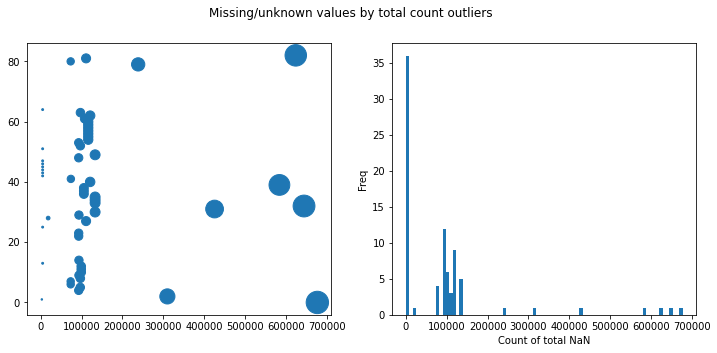

In [21]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

def plot_NaN_Count(df,v_dict):
    """
    Plot the NaN values count in the dataframe df

    INPUT:
    Dataframe df and a dictionary
    of features and the corresponding
    missing/unknown values encoding list
    
    OUTPUT:
    None 
    """
    counts_list=[]
    labels_list=[]
    for key in v_dict.keys():
        count_NaN = df[key].isnull().sum()
        counts_list.append(count_NaN)
        labels_list.append(key)
    counts_array = np.array(counts_list)
    labels_array = np.array(labels_list)
    n_bins = len(counts_array)
    index_list = [labels_list.index(item) for item in labels_list]
    dot_size = [(val-min(counts_list))/(max(counts_list)-min(counts_list))*500 for val in counts_list]
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    fig.suptitle('Missing/unknown values by total count outliers')
    axes[0].scatter(counts_array,index_list,s=dot_size)
    axes[1].hist(counts_array,bins=n_bins)
    plt.xlabel('Count of total NaN')
    plt.ylabel('Freq')
    plt.show()

plot_NaN_Count(general_data,unknown_or_missing_dict)

In [22]:
# Investigate patterns in the amount of missing data in each column.

# Based on the charts above, features with the top 7 total NaN count are outliers
def get_outliers_drop_list(df,v_dict,n_outliers):
    """
    Get the list of outlier NaN features to drop
    
    INPUT:
    Dataframe df, a dict of its features
    and the number of top outlier total NaN
    count to drop.
    
    OUTPUT:
    Return list of features to drop"""
    counts_list=[]
    labels_list=[]
    for key in v_dict.keys():
        count_NaN = df[key].isnull().sum()
        counts_list.append(count_NaN)
        labels_list.append(key)
    total_NaN = dict(zip(labels_list,counts_list))
    rev_sort_total_NaN = sorted(total_NaN, key = total_NaN.get, reverse=True)[:n_outliers]
    return(rev_sort_total_NaN)  

In [23]:
# List of outlier columns to drop

outlier_columns = get_outliers_drop_list(general_data,unknown_or_missing_dict,7)
print(outlier_columns)

['AGER_TYP', 'KBA05_ANTG3', 'WOHNDAUER_2008', 'KK_KUNDENTYP', 'KBA05_ANTG2', 'ALTER_HH', 'SHOPPER_TYP']


In [24]:
# Drop outlier columns and 
general_data = general_data.drop(columns = get_outliers_drop_list(general_data,unknown_or_missing_dict,7))


In [25]:
len(general_data.columns)

79

### Prepare Data - Step 3 : Assess missing row values

This is to determine the distribution of missing values in row and the outlier rows in terms of missing values. Based on the visualization below, Some outlier row missing values exists.

In [26]:
# Create a new column for missing row values
general_data['total_row_missing_data'] = general_data.isnull().sum(axis=1)

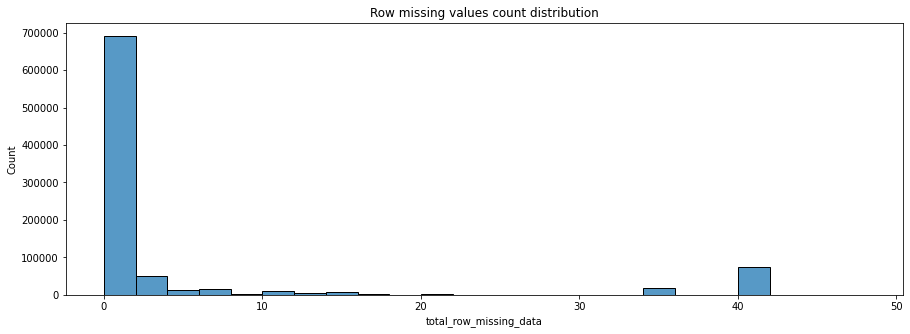

In [27]:
# Distribution plot of missing row values

plt.figure(figsize=(15,5))
sns.histplot(general_data,x=general_data['total_row_missing_data'],binwidth = 2).set(title='Row missing values count distribution')
plt.show()

### Prepare Data - Step 4 : Compare the distribution of values between more and less missing values rows

The data is split into two, more missing row values and less missing row values. Based on the visualization of missing row values count above, the boundary is take at 20 missing values in a row. Some comes are compared between these two datasets to determine if the difference in the distribution of values among them is significant using the visualization below. There seems to be no significant difference in the distribution of row values between the few missing rows dataset and the more missing rows dataset. Therefore this analysis will proceed with the few missing rows dataset.

In [28]:
# Split the general data into few missing and more missing row data 
# taking 20 missing values count as the threshold

general_few_missing = general_data.loc[general_data['total_row_missing_data']<= 20]

general_more_missing = general_data.loc[general_data['total_row_missing_data'] > 20]

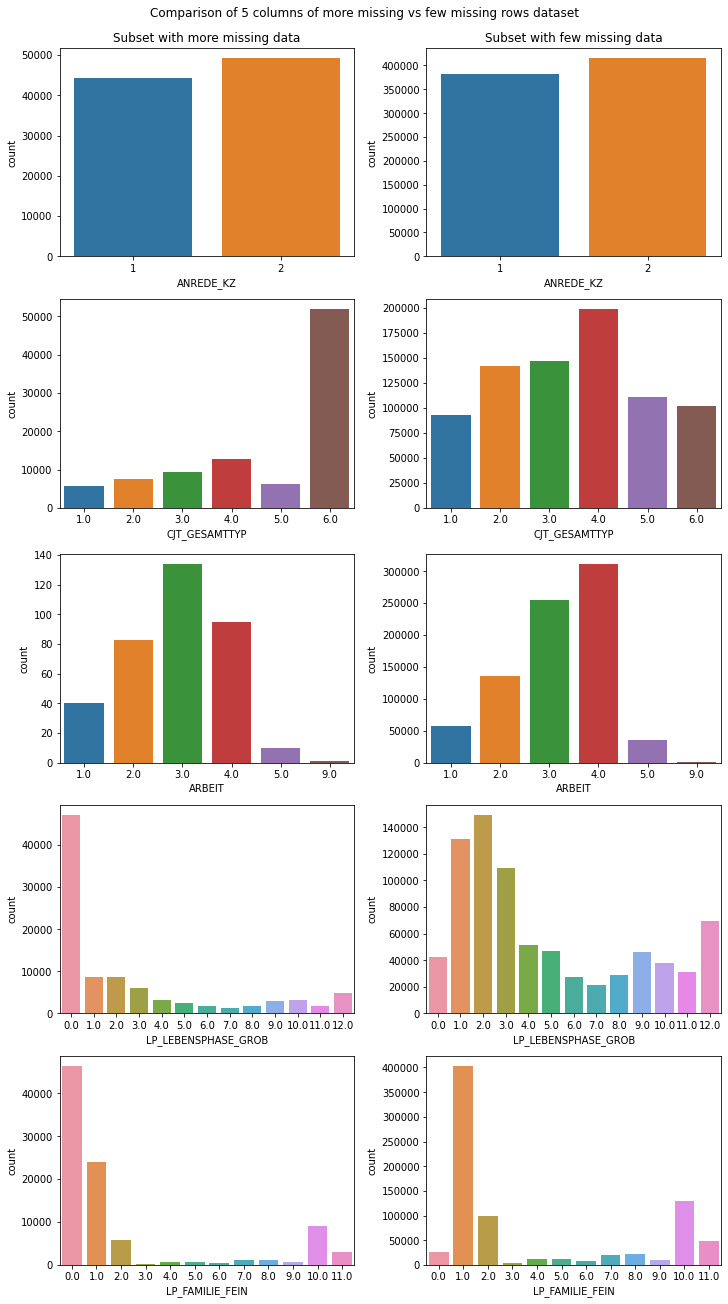

In [29]:
# Comparing the row missing values between the more missing and
# few missing data

fig, axes = plt.subplots(5, 2, figsize=(10,18),constrained_layout=True)
fig.suptitle('Comparison of 5 columns of more missing vs few missing rows dataset')
axes[0,0].set_title('Subset with more missing data')
axes[0,1].set_title('Subset with few missing data')
sns.countplot(x= general_more_missing['ANREDE_KZ'],data= general_more_missing,ax= axes[0,0])
sns.countplot(x= general_more_missing['CJT_GESAMTTYP'],data= general_more_missing,ax= axes[1,0])
sns.countplot(x= general_more_missing['ARBEIT'],data= general_more_missing,ax= axes[2,0])
sns.countplot(x= general_more_missing['LP_LEBENSPHASE_GROB'],data= general_more_missing,ax= axes[3,0])
sns.countplot(x= general_more_missing['LP_FAMILIE_FEIN'],data= general_more_missing,ax= axes[4,0])
sns.countplot(x= general_few_missing['ANREDE_KZ'],data= general_few_missing,ax= axes[0,1])
sns.countplot(x= general_few_missing['CJT_GESAMTTYP'],data= general_few_missing,ax= axes[1,1])
sns.countplot(x= general_few_missing['ARBEIT'],data= general_few_missing,ax= axes[2,1])
sns.countplot(x= general_few_missing['LP_LEBENSPHASE_GROB'],data= general_few_missing,ax= axes[3,1])
sns.countplot(x= general_few_missing['LP_FAMILIE_FEIN'],data= general_few_missing,ax= axes[4,1])
plt.show()

### Prepare Data - Step 5 : One-Hot Encode Categorical Features Using Pandas  get_dummies

First is to get the list of categorical variables to be encoded. Then those with categories greater than 2
are one-hot encoding. 'OST_WEST_KZ' with unique values 'O' and 'W' is Re-encode as integer values 0 and 1 and cast feature to float.

In [30]:
categorical_features = feature_unknown_or_missing.loc[feature_unknown_or_missing['type'].isin(['categorical'])]

categorical_list = categorical_features['Attribute'].values.tolist() 

reencode_features_list = [val for val in  categorical_list if val not in outlier_columns]

print(reencode_features_list)

['ANREDE_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP']


In [31]:
general_few_missing.OST_WEST_KZ.unique()

array(['W', 'O'], dtype=object)

In [32]:
conditions = [
    (general_few_missing['OST_WEST_KZ']== 'O'),
    (general_few_missing['OST_WEST_KZ']== 'W')]
setvalues = ['0','1']
general_few_missing['OST_WEST_KZ'] = np.select(conditions,setvalues, default=0)

# Cast feature to float
general_few_missing['OST_WEST_KZ'] = general_few_missing['OST_WEST_KZ'].astype('float')

# Verify the encoding
print(set(list(general_few_missing['OST_WEST_KZ'])))  

{0.0, 1.0}


In [33]:
# Get categorical dataset to be encoded from general_few_missing

all_categorical_features = general_few_missing[reencode_features_list]

In [34]:
# onehot encode categorical features with categories creater than 2

hot_encode_list = [val for val in all_categorical_features if len(set(list(general_few_missing[val]))) > 2]

# Remove the feature with the highest categories from the onehot encoding list
hot_encode_list.remove('CAMEO_DEU_2015')

#onehot encode using pandas get dummies

pd.get_dummies(data = general_few_missing, columns = hot_encode_list)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_INTL_2015,EWDICHTE,FINANZ_ANLEGER,...,TITEL_KZ_4.0,TITEL_KZ_5.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
1,11.0,0.0,2.0,0.0,3.0,6.0,8A,51,3.0,5,...,0,0,0,1,0,0,0,0,1,0
2,10.0,0.0,1.0,0.0,3.0,2.0,4C,24,4.0,2,...,0,0,1,0,0,0,0,0,1,0
3,1.0,0.0,0.0,0.0,2.0,4.0,2A,12,2.0,2,...,0,0,1,0,0,0,1,0,0,0
4,3.0,0.0,4.0,0.0,4.0,2.0,6B,43,5.0,1,...,0,0,0,1,0,0,0,1,0,0
5,5.0,0.0,1.0,0.0,2.0,6.0,8C,54,2.0,2,...,0,0,0,1,0,0,0,1,0,0
6,4.0,0.0,1.0,0.0,4.0,6.0,4A,22,4.0,5,...,0,0,1,0,0,0,0,1,0,0
7,6.0,0.0,1.0,0.0,2.0,2.0,2D,14,5.0,1,...,0,0,1,0,1,0,0,0,0,0
8,2.0,1.0,1.0,0.0,2.0,3.0,1A,13,4.0,4,...,0,0,0,1,0,0,0,0,0,1
9,9.0,0.0,1.0,0.0,2.0,6.0,1E,15,5.0,3,...,0,0,0,1,0,0,0,1,0,0
10,6.0,0.0,1.0,0.0,4.0,6.0,9D,51,4.0,3,...,0,0,0,1,0,0,1,0,0,0


### Prepare Data - Step 6 : Engineer mixed type features to create new features

Starting with PRAEGENDE_JUGENDJAHRE which shows generation by decade and nation(east vs. west). Because there is no enough information to group into east or west, this feature would be engineered into a binary MOVEMENT feature(Mainstream vs. Avantgarde). Then a GENERATIONS interval-type variable. Next is the CAMEO_INTL_2015. This feature provide information about wealth and life stage of customers. These are broken down in 'ones'-place digits into an ordinal feature WEALTH_LIFE and in 'tens'-place into an ordinal feature TYPOLOGY. Lastly, object type variables are cast into float and features that has been engineered dropped from the dataset.

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables. MOVEMENT and GENERATIONS

#Available distinct values of the praegende_jugendjahre feature to be encoded

# Based on the DIAS Information Level - Attributes 2017 csv, a movement feature as binary is created

general_few_missing['MOVEMENT'] = np.where(general_few_missing['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),0,1)

# Based on the data dictionary, create a generation feature as intervals
conditions = [
    (general_few_missing['PRAEGENDE_JUGENDJAHRE'].isin([1,2])),
    (general_few_missing['PRAEGENDE_JUGENDJAHRE'].isin([3,4])),
    (general_few_missing['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7])),
    (general_few_missing['PRAEGENDE_JUGENDJAHRE'].isin([8,9])),
    (general_few_missing['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13])),
    (general_few_missing['PRAEGENDE_JUGENDJAHRE'].isin([14,15]))]
setvalues = [1,2,3,4,5,6]
     
general_few_missing['GENERATIONS'] = np.select(conditions,setvalues, default=0)

general_few_missing['GENERATIONS'] = general_few_missing['GENERATIONS'].astype('float')

In [36]:
# The feature "CAMEO_INTL_2015" is of type object and the values are str type and must be cast to float

general_few_missing['CAMEO_INTL_2015']= general_few_missing['CAMEO_INTL_2015'].astype('float')

# Based on the data dictionary, create WEALTH_LIFE feature
conditions = [
    (general_few_missing['CAMEO_INTL_2015'].isin([11,12,13,14,15])),
    (general_few_missing['CAMEO_INTL_2015'].isin([21,22,23,24,25])),
    (general_few_missing['CAMEO_INTL_2015'].isin([31,32,33,34,35])),
    (general_few_missing['CAMEO_INTL_2015'].isin([41,42,43,44,45])),
    (general_few_missing['CAMEO_INTL_2015'].isin([51,52,53,54,55]))]
setvalues = [1,2,3,4,5]
     
general_few_missing['WEALTH_LIFE'] = np.select(conditions,setvalues, default=0)


# Based on the data dictionary, create TYPOLOGY feature
conditions = [
    (general_few_missing['CAMEO_INTL_2015'].isin([11,21,31,41,51])),
    (general_few_missing['CAMEO_INTL_2015'].isin([12,22,32,42,52])),
    (general_few_missing['CAMEO_INTL_2015'].isin([13,23,33,43,53])),
    (general_few_missing['CAMEO_INTL_2015'].isin([14,24,34,44,54])),
    (general_few_missing['CAMEO_INTL_2015'].isin([15,25,35,45,55]))]
setvalues = [1,2,3,4,5]
     
general_few_missing['TYPOLOGY'] = np.select(conditions,setvalues, default=0)

In [37]:
# The feature CAMEO_DEUG_2015 is of object type and has to be cast into a float.

general_few_missing['CAMEO_DEUG_2015'] = general_few_missing['CAMEO_DEUG_2015'].astype('float')

Drop from the dataset features engineered into other features above including CAMEO_DEU_2015 which is having the highest categories.

In [38]:
general_few_missing = general_few_missing.drop(columns= ['CAMEO_DEU_2015','PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','total_row_missing_data'])


### Prepare Data - Step 7 : Create a cleaning function

Below is a cleaning function which includes all the cleaning steps applyed to the general population data. This function would be used in cleaning the customers dataset.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    apply_NaN_values(df,unknown_dict)
    
    # remove selected columns and rows, ... 'COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC'
    for column in outlier_columns:
        if column in df.columns:
            df = df.drop(column, axis=1)
    #df = df.drop(columns=outlier_columns)
    
    # use only rows with number of row null values less than or equal 20
    df['total_row_missing_data'] = df.isnull().sum(axis=1)
    df = df.loc[df['total_row_missing_data']<=20]
    
    # select, re-encode, and engineer column values.
    conditions = [(df['OST_WEST_KZ']== 'O'),(df['OST_WEST_KZ']== 'W')]
    setvalues = ['0','1']
    df['OST_WEST_KZ'] = np.select(conditions,setvalues, default=0)
    # Cast feature to int
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].astype('float')
    #onehot encoding
    pd.get_dummies(data = df, columns = hot_encode_list)
    # Based on the data dictionary, create a movement feature as binary
    df['MOVEMENT'] = np.where(df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),0,1)
    # Based on the data dictionary, create a generation feature as intervals
    conditions = [(df['PRAEGENDE_JUGENDJAHRE'].isin([1,2])),(df['PRAEGENDE_JUGENDJAHRE'].isin([3,4])),(df['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7])),(df['PRAEGENDE_JUGENDJAHRE'].isin([8,9])),(df['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13])),(df['PRAEGENDE_JUGENDJAHRE'].isin([14,15]))]
    setvalues = setvalues = [1,2,3,4,5,6]
    df['GENERATIONS'] = np.select(conditions,setvalues, default=0)
    # The feature "CAMEO_INTL_2015" is of type object and the values are str type and must be cast to int
    df['CAMEO_INTL_2015']= df['CAMEO_INTL_2015'].astype('float')
    # Based on the data dictionary, create WEALTH_LIFE feature
    conditions = [(df['CAMEO_INTL_2015'].isin([11,12,13,14,15])),(df['CAMEO_INTL_2015'].isin([21,22,23,24,25])),(df['CAMEO_INTL_2015'].isin([31,32,33,34,35])),(df['CAMEO_INTL_2015'].isin([41,42,43,44,45])),(df['CAMEO_INTL_2015'].isin([51,52,53,54,55]))]
    setvalues = [1,2,3,4,5]
    df['WEALTH_LIFE'] = np.select(conditions,setvalues, default=0)
    # Based on the data dictionary, create TYPOLOGY feature
    conditions = [(df['CAMEO_INTL_2015'].isin([11,21,31,41,51])),(df['CAMEO_INTL_2015'].isin([12,22,32,42,52])),(df['CAMEO_INTL_2015'].isin([13,23,33,43,53])),(df['CAMEO_INTL_2015'].isin([14,24,34,44,54])),(df['CAMEO_INTL_2015'].isin([15,25,35,45,55]))]
    setvalues = [1,2,3,4,5]
    df['TYPOLOGY'] = np.select(conditions,setvalues, default=0)
    # cast the feature "CAMEO_DEUG_2015" as float
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float')
    df = df.drop(columns= ['CAMEO_DEU_2015','PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','total_row_missing_data'])
    # Return the cleaned dataframe.
    return(df)


###  Unsupervised learning - Step 1: Fill NaN values using Sklearn SimpleImputer and apply feature scaling

The strategy is to fill NaN values with the median value of each column. The choice of median was to minimize the influence of outliers which would have been the case using mean strategy.

In [40]:
# create final features list

final_features = list(general_few_missing.columns)

In [41]:
general_few_missing.columns

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'ARBEIT', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'EWDICHTE',
       'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER',
       'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GEBURTSJAHR',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ANTG1', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_GBZ', 'KBA13_ANZAHL_PKW', 'KBA13_AUTOQUOTE',
       'KBA13_TOYOTA', 'KKK', 'KONSUMNAEHE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'MOBI_REGIO',
       'NATIONALITAET_KZ', 'ONLINE_AFFINITAET', 'ORTSGR_KLS9', 'OST_WEST_KZ',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX',
       'PLZ8_GBZ', 'PLZ8_HHZ', 'REGIOTYP', 'RELAT_AB', 'RETOURTY

In [42]:
print(final_features)

['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'EWDICHTE', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ANTG1', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KBA13_ANZAHL_PKW', 'KBA13_AUTOQUOTE', 'KBA13_TOYOTA', 'KKK', 'KONSUMNAEHE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'MOBI_REGIO', 'NATIONALITAET_KZ', 'ONLINE_AFFINITAET', 'ORTSGR_KLS9', 'OST_WEST_KZ', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'REGIOTYP', 'RELAT_AB', 'RETOURTYP_BK_S', 'SEMIO_DOM', 'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_

In [43]:
# Replace NaN values suing the median of each column 
imputer = SimpleImputer(missing_values=np.nan, strategy='median').fit(general_few_missing)

In [44]:
# Transform data

general_imputer= imputer.transform(general_few_missing)

In [45]:
# Convert the array to dataframe

general_imputer=pd.DataFrame(general_imputer, columns = final_features)

general_imputer.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,...,VERS_TYP,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,MOVEMENT,GENERATIONS,WEALTH_LIFE,TYPOLOGY
0,11.0,0.0,2.0,0.0,3.0,6.0,8.0,5.0,3.0,5.0,...,2.0,3.0,4.0,5.0,2.0,1.0,1.0,6.0,5.0,1.0
1,10.0,0.0,1.0,0.0,3.0,2.0,4.0,3.0,4.0,2.0,...,1.0,3.0,2.0,5.0,2.0,3.0,0.0,6.0,2.0,4.0
2,1.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,2.0,2.0,...,1.0,4.0,7.0,3.0,2.0,4.0,1.0,4.0,1.0,2.0
3,3.0,0.0,4.0,0.0,4.0,2.0,6.0,5.0,5.0,1.0,...,2.0,2.0,3.0,4.0,1.0,3.0,1.0,4.0,4.0,3.0
4,5.0,0.0,1.0,0.0,2.0,6.0,8.0,2.0,2.0,2.0,...,2.0,6.0,7.0,4.0,2.0,1.0,1.0,2.0,5.0,4.0


In [46]:
# Verify there is no NaN value anymore in dataset
general_imputer.isnull().values.any()

False

### Unsupervised learning - Step 2: Apply feature scaling to the general_few_missing dataset.

Because of the different scales used for the values in the data, feature scaling is needed before using distance based algorithms on the data or dimensionality reduction using PCA.

In [47]:
# Apply feature scaling to the general population demographics data.

# Scale, fit and transform the data

scaler = RobustScaler().fit(general_imputer) # Fit

general_normalize = scaler.transform(general_imputer) # transform the data

general_normalize = pd.DataFrame(general_normalize,columns=final_features) # create a dataframe

general_normalize.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,...,VERS_TYP,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,MOVEMENT,GENERATIONS,WEALTH_LIFE,TYPOLOGY
0,0.875,0.0,1.0,0.0,0.0,0.25,0.4,0.333333,-0.25,0.666667,...,0.0,-0.333333,0.5,2.0,0.0,-1.0,0.0,0.666667,0.333333,-0.666667
1,0.750,0.0,0.0,0.0,0.0,-0.75,-0.4,-0.333333,0.00,-0.333333,...,-1.0,-0.333333,-0.5,2.0,0.0,0.0,-1.0,0.666667,-0.666667,0.333333
2,-0.375,0.0,-1.0,0.0,-1.0,-0.25,-0.8,-0.666667,-0.50,-0.333333,...,-1.0,0.000000,2.0,0.0,0.0,0.5,0.0,0.000000,-1.000000,-0.333333
3,-0.125,0.0,3.0,0.0,1.0,-0.75,0.0,0.333333,0.25,-0.666667,...,0.0,-0.666667,0.0,1.0,-1.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.125,0.0,0.0,0.0,-1.0,0.25,0.4,-0.666667,-0.50,-0.333333,...,0.0,0.666667,2.0,1.0,0.0,-1.0,0.0,-0.666667,0.333333,0.333333


### Unsupervised learning - Step 3: Perform Dimensionality Reduction using PCA

PCA is used to apply principal component analysis on the data to find the vectors of maximal variance in the data. First, no parameter is set to allow the computation of all components. Using the ratio of variance explained by each principal component and the cumulative variance explained, the value for the number of transformed features to retain for clustering was decided.

In [48]:
#Plots and Kmeans fitting functions taken from my Udacity classroom with none or little modification to fit purpose

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions
	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)


# Make the images larger
plt.rcParams['figure.figsize'] = (16, 9)

def fit_kmeans(data, centers):
    '''INPUT:
    data = the dataset you would like to fit kmeans to (dataframe)
    centers = the number of centroids (int)
    
    OUTPUT:
    labels - the labels for each datapoint to which group it belongs (nparray)
    '''
    kmeans = KMeans(centers)
    labels = kmeans.fit_predict(data)
    return labels

def get_kmeans_score(data, center):
    '''returns the kmeans score regarding SSE for points to centers
    INPUT:
    data - the dataset you want to fit kmeans to
    center - the number of centers you want (the k value)
    OUTPUT:
    score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    return score

In [49]:
# Apply PCA to the data.

pca = PCA(random_state=42).fit(general_normalize) # Fit

general_pca = pca.transform(general_normalize) # Transform

array([2.32884701e-01, 1.51473093e-01, 6.64214969e-02, 5.74165963e-02,
       4.99489726e-02, 4.17223743e-02, 4.07897317e-02, 3.31287431e-02,
       3.04526764e-02, 2.48953631e-02, 2.32054579e-02, 1.64869067e-02,
       1.48254369e-02, 1.40228760e-02, 1.27733010e-02, 1.14135145e-02,
       9.82681716e-03, 9.18895243e-03, 8.47019820e-03, 8.15622116e-03,
       7.28605153e-03, 6.91794913e-03, 5.78597283e-03, 5.61532971e-03,
       5.42486903e-03, 5.23741916e-03, 5.10926116e-03, 4.87950674e-03,
       4.69752137e-03, 4.65438654e-03, 4.27844168e-03, 4.09793157e-03,
       3.86032128e-03, 3.69394922e-03, 3.46362037e-03, 3.37957450e-03,
       3.28484918e-03, 3.05091366e-03, 3.01643200e-03, 2.86887401e-03,
       2.74295505e-03, 2.68208666e-03, 2.64214078e-03, 2.52902468e-03,
       2.47905084e-03, 2.33411292e-03, 2.24891814e-03, 2.09892090e-03,
       2.09244233e-03, 2.07779851e-03, 2.04543297e-03, 1.97688900e-03,
       1.94936815e-03, 1.84881083e-03, 1.74202053e-03, 1.70150736e-03,
      

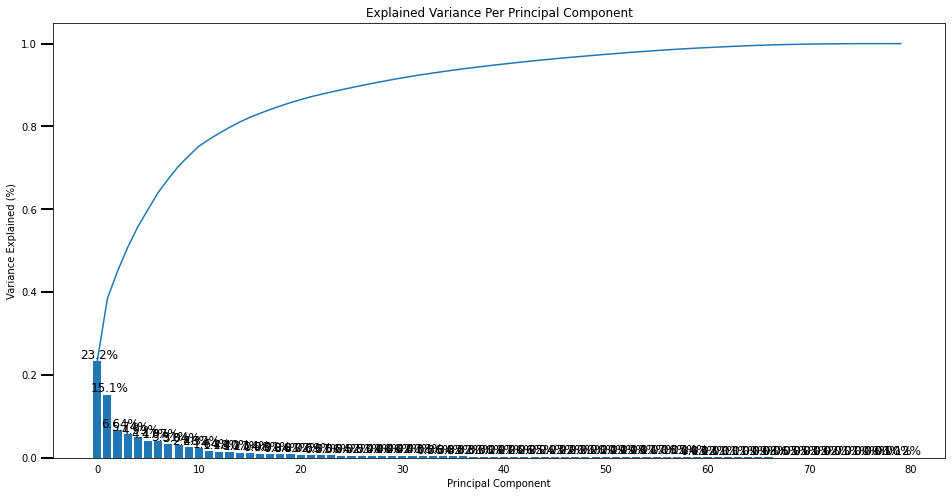

In [50]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca)

pca.explained_variance_ratio_

In [51]:
# Get the number of principle components that cumulatively account for 95% explanation of the data.

pca_results_df = pca_results(general_normalize,pca)

pca_results_variance = pca_results_df['Explained Variance'].cumsum()

pca_results_variance.head(44)

Dimension 1     0.2329
Dimension 2     0.3844
Dimension 3     0.4508
Dimension 4     0.5082
Dimension 5     0.5581
Dimension 6     0.5998
Dimension 7     0.6406
Dimension 8     0.6737
Dimension 9     0.7042
Dimension 10    0.7291
                 ...  
Dimension 35    0.9326
Dimension 36    0.9360
Dimension 37    0.9393
Dimension 38    0.9424
Dimension 39    0.9454
Dimension 40    0.9483
Dimension 41    0.9510
Dimension 42    0.9537
Dimension 43    0.9563
Dimension 44    0.9588
Name: Explained Variance, Length: 44, dtype: float64

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.

# 44 components explained 95% information of the data

pca = PCA(n_components=44,random_state=42).fit(general_normalize)

general_pca = pca.transform(general_normalize)

### Interpret Principal Componets

Based on Udacity class description, each principal component is a unit vector poining in the direction of the highest variance. The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. Two features having large weights of the same sign (both postive or negative) are directly related, such that an increase in one is associated with an increase in the other. Similarly, if they are of opposite sign they are inversely related such that an increase in one results in a decrease in the other.


The first step would be to map each weight to their corresponding feature name, the sort the features according to weight. The most interesting features for each prinicipal component, then, will be those at the beginning and end of the sort list. 

The positive or negative values shows the influence of the feature dimension of the principle component. The higher postive and negative values provides more explanation of the principal component. The negative values indicates inverse correlation.

In [53]:
# Convert the fitted and transformed pca to dataframe

pca_dataframe = pd.DataFrame(general_pca)
pca_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-2.378396,1.621385,-2.423476,0.890809,-0.774955,-1.870293,2.193261,-1.997872,-1.480656,0.581765,...,0.196301,0.067340,0.087345,-0.556559,0.388449,-0.424759,-0.384950,-0.553514,-0.467639,0.210479
1,-0.983297,-0.900064,-0.133664,0.206683,-2.399282,-0.582338,1.510492,0.497061,1.602615,0.422247,...,-0.206146,0.036355,0.047808,0.124716,-0.447460,0.322253,0.197555,0.207585,-0.182913,-0.202866
2,4.479094,-0.317705,1.777185,-0.209244,-1.989247,-0.726125,-1.051003,-1.067163,2.332573,1.511949,...,0.658057,0.060053,-0.975533,-0.483425,-0.039382,-1.167584,-0.601543,0.258867,0.173375,-0.652843
3,-0.932240,-0.920811,-0.299141,-1.204762,2.877659,1.284036,-0.002342,1.496548,-1.171746,1.289701,...,-0.045605,0.044352,0.035824,0.555353,0.319042,0.160319,0.022320,-0.042663,0.063758,-0.136951
4,-0.599110,-1.571137,-2.097190,0.813809,-2.445234,-1.127315,-0.129359,1.920351,-0.971760,-0.525841,...,0.076709,0.634797,0.310083,-0.391448,-0.063444,-0.053857,0.403997,-0.762476,-0.058144,0.550197


In [54]:
# Weight of principle components

pd.DataFrame(pca.components_)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-0.209531,-0.010836,0.055579,-0.000005,-0.079256,0.041076,-0.059759,0.001307,-0.052549,0.007431,...,-0.019355,-0.035398,0.051459,-0.105725,-0.003206,0.003762,-0.015172,0.006551,-0.062052,0.022034
1,0.363576,0.018446,-0.121608,-0.000156,0.142361,-0.063520,0.093954,0.015222,0.078298,0.011931,...,0.007882,0.022683,-0.082280,0.187745,0.004754,-0.031966,0.040547,0.018617,0.087767,-0.056811
2,0.244759,0.023420,-0.048594,0.000894,0.018405,-0.016110,-0.008536,-0.098655,0.014884,-0.162632,...,0.013325,0.093575,-0.041631,-0.253668,0.037237,0.226076,-0.024879,-0.195600,-0.005721,0.034976
3,0.802282,0.054341,0.081834,-0.000252,-0.191636,0.040496,-0.028371,0.014458,-0.070995,0.045753,...,-0.010097,-0.042219,0.153448,-0.020066,-0.021459,-0.038721,0.019587,0.031118,-0.030857,0.015316
4,0.072706,0.009497,0.482722,0.001801,0.101959,-0.061012,-0.011377,0.036205,0.064796,-0.042721,...,-0.000699,-0.102803,-0.137538,-0.410523,-0.113226,-0.021803,-0.083929,0.021339,-0.011665,0.003308
5,0.030499,-0.006008,0.110697,-0.001140,0.064607,0.050304,0.035377,-0.003772,-0.052319,0.054707,...,-0.004373,-0.028407,0.177997,0.145106,0.040518,0.012174,0.065115,0.007708,0.033390,-0.009251
6,0.026410,0.002404,0.338601,0.000253,-0.000496,-0.020769,-0.010250,0.037800,0.023968,0.092733,...,0.006715,-0.155831,-0.078896,0.136498,0.268019,-0.031296,-0.006794,0.055796,-0.008150,0.004261
7,0.119286,0.003693,0.023524,-0.000959,0.114772,0.003426,0.039684,-0.001291,0.023010,-0.004691,...,0.008372,0.024546,-0.069462,0.072867,-0.038936,0.008487,0.019911,-0.011745,0.041869,-0.007033
8,0.103785,0.022392,-0.222220,0.000785,0.033825,-0.042744,-0.076539,0.019344,0.034147,0.012322,...,-0.012578,0.004754,-0.173150,-0.205112,0.082585,-0.073620,-0.075376,0.038634,-0.076788,0.041346
9,-0.081119,0.000442,0.174290,0.000742,-0.158134,0.034092,0.010788,-0.024747,-0.043970,-0.068111,...,-0.003357,-0.058229,0.204511,0.595196,-0.084990,0.070678,0.022691,-0.004126,0.008978,-0.021788


In [55]:
# print principal component and the feature names function

def pca_weight_map(comp_n,pca,dataset):
    component_df = pd.DataFrame(pca.components_.T, index=dataset.columns)
    weight_feature_map = component_df[comp_n].sort_values(ascending=False)
    print(weight_feature_map)

In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_map(0,pca,general_normalize)

MIN_GEBAEUDEJAHR       0.868584
KBA13_AUTOQUOTE        0.128374
PLZ8_ANTG1             0.102793
PLZ8_GBZ               0.089223
KONSUMNAEHE            0.083788
MOBI_REGIO             0.082566
FINANZ_MINIMALIST      0.068453
KBA05_GBZ              0.068405
GEBAEUDETYP_RASTER     0.067651
LP_STATUS_GROB         0.063997
                         ...   
PLZ8_ANTG2            -0.076282
PLZ8_ANTG4            -0.078173
ARBEIT                -0.079256
GEBAEUDETYP           -0.081384
PLZ8_BAUMAX           -0.089402
ORTSGR_KLS9           -0.092624
FINANZ_HAUSBAUER      -0.100275
ZABEOTYP              -0.105725
PLZ8_ANTG3            -0.110259
ANZ_HAUSHALTE_AKTIV   -0.209531
Name: 0, Length: 80, dtype: float64


In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_map(1,pca,general_normalize)

MIN_GEBAEUDEJAHR       0.483211
ANZ_HAUSHALTE_AKTIV    0.363576
PLZ8_ANTG3             0.225099
ZABEOTYP               0.187745
PLZ8_ANTG4             0.170209
PLZ8_BAUMAX            0.157544
ORTSGR_KLS9            0.145724
ARBEIT                 0.142361
KBA05_BAUMAX           0.127286
PLZ8_ANTG2             0.127212
                         ...   
INNENSTADT            -0.106682
GEBAEUDETYP_RASTER    -0.116464
FINANZ_MINIMALIST     -0.117245
KONSUMNAEHE           -0.118709
ANZ_PERSONEN          -0.121608
KBA05_GBZ             -0.142963
MOBI_REGIO            -0.169200
PLZ8_GBZ              -0.210275
KBA13_AUTOQUOTE       -0.211825
PLZ8_ANTG1            -0.230605
Name: 1, Length: 80, dtype: float64


In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_map(2,pca,general_normalize)

ANZ_HAUSHALTE_AKTIV     0.244759
ALTERSKATEGORIE_GROB    0.226076
SEMIO_ERL               0.209303
FINANZ_VORSORGER        0.171157
FINANZ_MINIMALIST       0.155728
SEMIO_LUST              0.155525
RETOURTYP_BK_S          0.113296
FINANZTYP               0.097757
W_KEIT_KIND_HH          0.093575
SEMIO_KRIT              0.068929
                          ...   
FINANZ_ANLEGER         -0.162632
SEMIO_MAT              -0.175904
GENERATIONS            -0.195600
FINANZ_SPARER          -0.198951
SEMIO_KULT             -0.217593
SEMIO_TRADV            -0.232810
SEMIO_PFLICHT          -0.252363
ZABEOTYP               -0.253668
SEMIO_RAT              -0.281551
SEMIO_REL              -0.416277
Name: 2, Length: 80, dtype: float64


### Unsupervised learning - Step 4: Clustering using k-means clustering

The average within-cluster distances from each point to their assigned cluster's centroid is used to decide on the number of clusters to keep.

sklearn's KMeans class is used to perform the k-mean clustering on the PCA-transformed data. Cluster count of 10 was tested.

In [59]:
# Over a number of different cluster counts...

# run k-means clustering on the data and...
    
# compute the average within-cluster distances.
    
def fit_mods():
    scores = []
    centers = list(range(1,6))
    for center in centers:
        scores.append(get_kmeans_score(pca_dataframe, center))
    return centers, scores

In [60]:
clu_scores,clu_centers = fit_mods()

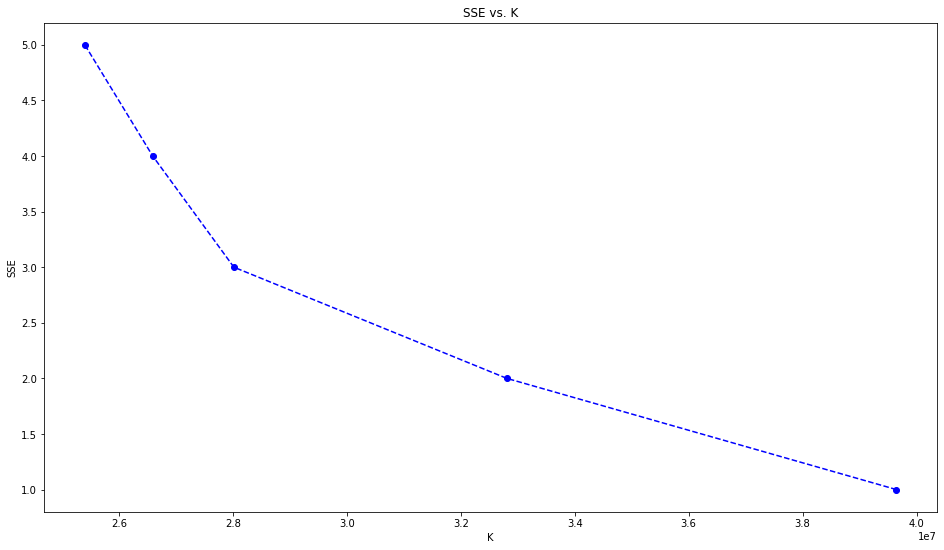

In [61]:
# Investigate the change in within-cluster distance across number of clusters.
# Use matplotlib's plot function to visualize this relationship.

plt.plot(clu_centers, clu_scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

### Unsupervised learning - Step 5: Apply Clustering to General Population

Using elbow method, the population is segmented into 2 clusters. Clusters above 2 leads to less average distance and more overlapping of clusters.

In [62]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmean_fit = fit_kmeans(pca_dataframe,2)

kmean_fit

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

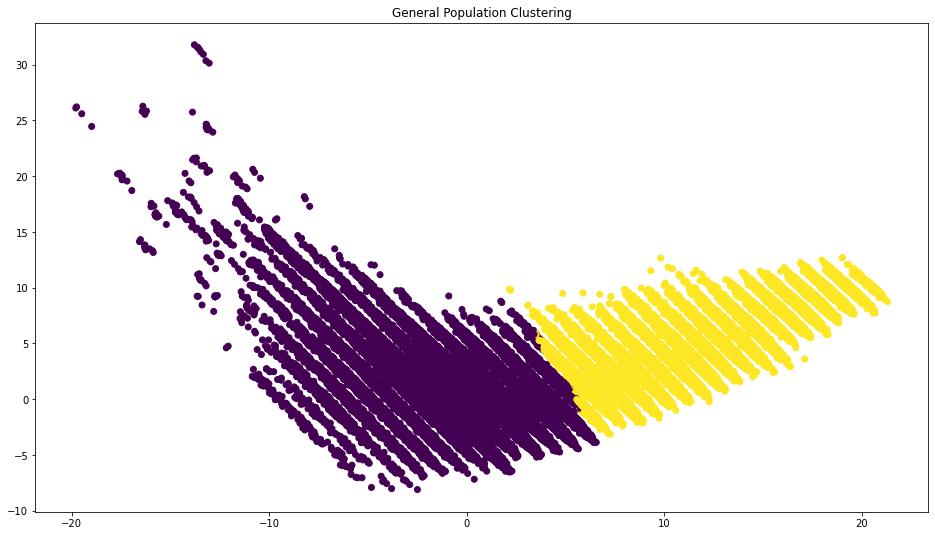

In [63]:
# plot of the first 2 components and the clusters
plt.scatter(general_pca[:,0],general_pca[:,1],c=kmean_fit)
plt.title('General Population Clustering');
plt.show()

### Unsupervised learning - Step 5: Apply same clustering to the Customer data

The above steps on the general data is to be applied to the customer data. First, customer data is cleaned using the clean_data function and finally the fits from the general population is used to clean, transform, and cluster the customer data.

In [64]:
# Preprocessing customer data

customers_cleaned = clean_data(customers)

In [65]:
#scale customer data

# Scale and transform the data

customer_imputer = imputer.transform(customers_cleaned)

customer_normalize = scaler.transform(customer_imputer) # transform the data

customer_normalize = pd.DataFrame(customer_normalize, columns = final_features) # create a dataframe

customer_normalize.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,...,VERS_TYP,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,MOVEMENT,GENERATIONS,WEALTH_LIFE,TYPOLOGY
0,-0.375,0.0,1.0,0.0,-2.0,-0.5,-1.0,0.333333,-0.50,-0.666667,...,-1.0,0.666667,2.0,0.0,-1.0,0.5,-1.0,-0.666667,-1.000000,0.000000
1,-0.375,0.0,0.0,0.0,0.0,0.5,-0.2,-0.666667,0.00,-0.666667,...,0.0,0.666667,-0.5,0.0,0.0,0.5,-1.0,-0.666667,-0.333333,0.333333
2,-0.500,0.0,-1.0,0.0,-2.0,0.5,-0.4,-0.666667,-0.75,-0.333333,...,-1.0,0.000000,2.0,-2.0,-1.0,0.5,0.0,-1.000000,-0.666667,0.333333
3,0.375,0.0,3.0,0.0,0.0,-0.5,0.2,0.666667,0.00,0.333333,...,0.0,-0.666667,0.0,-2.0,-1.0,0.0,0.0,0.000000,0.000000,-0.666667
4,-0.375,0.0,1.0,0.0,0.0,0.5,-0.2,0.000000,0.25,-0.666667,...,0.0,0.666667,-1.0,-1.0,-1.0,0.0,-1.0,-0.666667,-0.333333,0.333333


In [66]:
# perform pca on scaled dataset
customers_pca = pca.transform(customer_normalize)

array([0.2328847 , 0.15147309, 0.0664215 , 0.0574166 , 0.04994897,
       0.04172237, 0.04078973, 0.03312874, 0.03045268, 0.02489536,
       0.02320546, 0.01648691, 0.01482544, 0.01402288, 0.0127733 ,
       0.01141351, 0.00982682, 0.00918895, 0.0084702 , 0.00815622,
       0.00728605, 0.00691793, 0.00578589, 0.00561529, 0.00542472,
       0.00523731, 0.00510922, 0.00487943, 0.00469614, 0.0046542 ,
       0.00427766, 0.00409768, 0.00385973, 0.00368833, 0.00346259,
       0.00337895, 0.0032796 , 0.00303404, 0.00301218, 0.00285357,
       0.00273357, 0.00267315, 0.0026234 , 0.00248803])

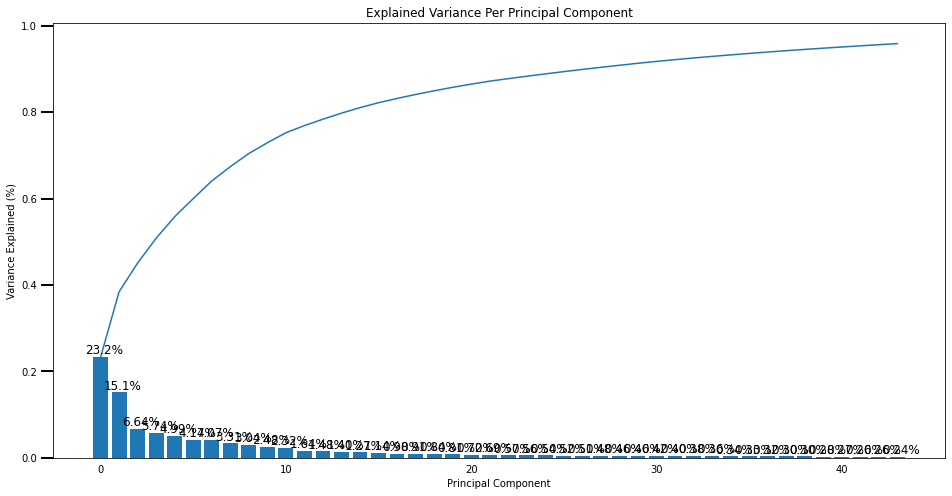

In [67]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)
pca.explained_variance_ratio_

In [68]:
# Re-apply PCA to the data while selecting for number of components to retain.

# For the customer dataset, the first 44 components already provided 95% 
# explanation of the data based on cumulative explained variance and is retained.

pca_customer_results_df = pca_results(customer_normalize,pca)

pca_customer_results_variance = pca_customer_results_df['Explained Variance'].cumsum()

pca_customer_results_variance.head(44)

Dimension 1     0.2329
Dimension 2     0.3844
Dimension 3     0.4508
Dimension 4     0.5082
Dimension 5     0.5581
Dimension 6     0.5998
Dimension 7     0.6406
Dimension 8     0.6737
Dimension 9     0.7042
Dimension 10    0.7291
                 ...  
Dimension 35    0.9326
Dimension 36    0.9360
Dimension 37    0.9393
Dimension 38    0.9423
Dimension 39    0.9453
Dimension 40    0.9482
Dimension 41    0.9509
Dimension 42    0.9536
Dimension 43    0.9562
Dimension 44    0.9587
Name: Explained Variance, Length: 44, dtype: float64

In [69]:
# Convert the fitted pca to dataframe

pca_dataframe_customer = pd.DataFrame(customers_pca)
pca_dataframe_customer.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.997370,-4.416798,1.447496,1.026431,-0.192085,-2.620747,-1.793371,0.345268,-0.223534,2.270913,...,0.180498,-0.077687,0.298156,0.121724,0.146537,0.593313,-0.384903,0.125705,-0.028639,0.157710
1,-1.633940,-0.001082,2.915283,-2.462702,-0.287430,0.156123,0.077639,-2.388271,-0.593509,-1.116892,...,-0.056395,-0.579379,-0.524241,0.951354,0.310336,0.804660,-0.299546,-0.317268,0.643153,-0.098771
2,0.554774,-3.624924,1.236374,0.611269,-1.380613,-0.159488,-3.080531,-0.195012,0.010310,-0.863206,...,0.131744,0.179521,-0.225658,-0.582603,0.054094,-0.284202,-0.128718,-0.158494,0.397954,-0.431772
3,-0.925492,-0.854066,-0.590619,-0.142808,3.385686,0.705737,0.605732,0.337151,-1.237763,-1.058065,...,-0.348290,-0.165469,0.057727,0.063311,0.960100,0.295660,0.280840,0.526750,-0.431325,0.208881
4,-0.511515,-1.922169,1.167069,-1.137577,1.206756,-3.107828,-0.699970,1.492167,0.279562,-0.235763,...,0.334722,0.363687,-0.166799,-0.437015,-0.473674,-0.205359,0.007373,0.013321,0.285729,-0.413379


In [70]:
# Weight of principle components

pd.DataFrame(pca.components_).head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-0.209531,-0.010836,0.055579,-0.000005,-0.079256,0.041076,-0.059759,0.001307,-0.052549,0.007431,...,-0.019355,-0.035398,0.051459,-0.105725,-0.003206,0.003762,-0.015172,0.006551,-0.062052,0.022034
1,0.363576,0.018446,-0.121608,-0.000156,0.142361,-0.063520,0.093954,0.015222,0.078298,0.011931,...,0.007882,0.022683,-0.082280,0.187745,0.004754,-0.031966,0.040547,0.018617,0.087767,-0.056811
2,0.244759,0.023420,-0.048594,0.000894,0.018405,-0.016110,-0.008536,-0.098655,0.014884,-0.162632,...,0.013325,0.093575,-0.041631,-0.253668,0.037237,0.226076,-0.024879,-0.195600,-0.005721,0.034976
3,0.802282,0.054341,0.081834,-0.000252,-0.191636,0.040496,-0.028371,0.014458,-0.070995,0.045753,...,-0.010097,-0.042219,0.153448,-0.020066,-0.021459,-0.038721,0.019587,0.031118,-0.030857,0.015316
4,0.072706,0.009497,0.482722,0.001801,0.101959,-0.061012,-0.011377,0.036205,0.064796,-0.042721,...,-0.000699,-0.102803,-0.137538,-0.410523,-0.113226,-0.021803,-0.083929,0.021339,-0.011665,0.003308


In [71]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_map(0,pca,customer_normalize)

MIN_GEBAEUDEJAHR       0.868584
KBA13_AUTOQUOTE        0.128374
PLZ8_ANTG1             0.102793
PLZ8_GBZ               0.089223
KONSUMNAEHE            0.083788
MOBI_REGIO             0.082566
FINANZ_MINIMALIST      0.068453
KBA05_GBZ              0.068405
GEBAEUDETYP_RASTER     0.067651
LP_STATUS_GROB         0.063997
                         ...   
PLZ8_ANTG2            -0.076282
PLZ8_ANTG4            -0.078173
ARBEIT                -0.079256
GEBAEUDETYP           -0.081384
PLZ8_BAUMAX           -0.089402
ORTSGR_KLS9           -0.092624
FINANZ_HAUSBAUER      -0.100275
ZABEOTYP              -0.105725
PLZ8_ANTG3            -0.110259
ANZ_HAUSHALTE_AKTIV   -0.209531
Name: 0, Length: 80, dtype: float64


In [72]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_map(1,pca,customer_normalize)

MIN_GEBAEUDEJAHR       0.483211
ANZ_HAUSHALTE_AKTIV    0.363576
PLZ8_ANTG3             0.225099
ZABEOTYP               0.187745
PLZ8_ANTG4             0.170209
PLZ8_BAUMAX            0.157544
ORTSGR_KLS9            0.145724
ARBEIT                 0.142361
KBA05_BAUMAX           0.127286
PLZ8_ANTG2             0.127212
                         ...   
INNENSTADT            -0.106682
GEBAEUDETYP_RASTER    -0.116464
FINANZ_MINIMALIST     -0.117245
KONSUMNAEHE           -0.118709
ANZ_PERSONEN          -0.121608
KBA05_GBZ             -0.142963
MOBI_REGIO            -0.169200
PLZ8_GBZ              -0.210275
KBA13_AUTOQUOTE       -0.211825
PLZ8_ANTG1            -0.230605
Name: 1, Length: 80, dtype: float64


In [73]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_map(2,pca,customer_normalize)

ANZ_HAUSHALTE_AKTIV     0.244759
ALTERSKATEGORIE_GROB    0.226076
SEMIO_ERL               0.209303
FINANZ_VORSORGER        0.171157
FINANZ_MINIMALIST       0.155728
SEMIO_LUST              0.155525
RETOURTYP_BK_S          0.113296
FINANZTYP               0.097757
W_KEIT_KIND_HH          0.093575
SEMIO_KRIT              0.068929
                          ...   
FINANZ_ANLEGER         -0.162632
SEMIO_MAT              -0.175904
GENERATIONS            -0.195600
FINANZ_SPARER          -0.198951
SEMIO_KULT             -0.217593
SEMIO_TRADV            -0.232810
SEMIO_PFLICHT          -0.252363
ZABEOTYP               -0.253668
SEMIO_RAT              -0.281551
SEMIO_REL              -0.416277
Name: 2, Length: 80, dtype: float64


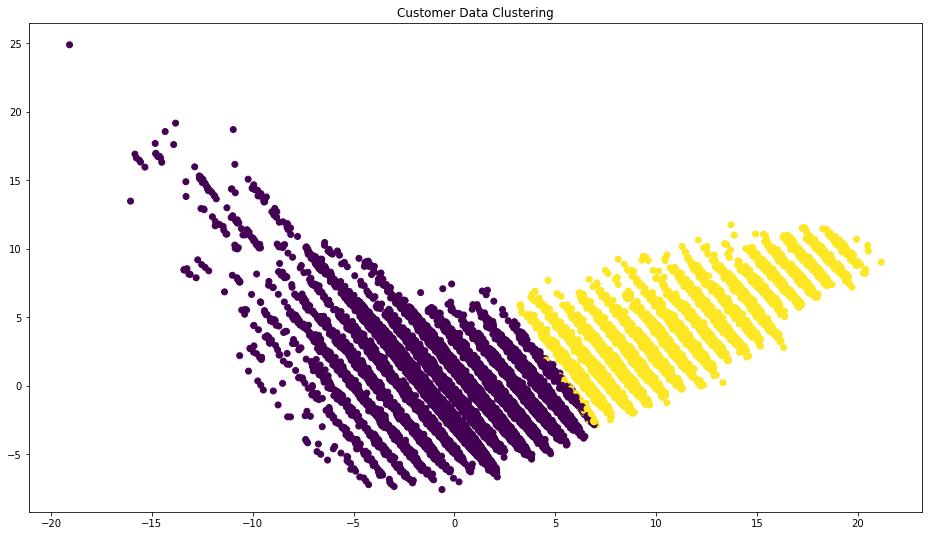

In [74]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the customer population demographics data.

customer_kmean_fit = fit_kmeans(pca_dataframe_customer, 2)
plt.scatter(customers_pca[:,0],customers_pca[:,1],c=customer_kmean_fit)
plt.title('Customer Data Clustering');
plt.show()

### Compare Customer data to General Demographics data

This involves inverse transforming reduced components of the general and customer data and comparing their person level features.

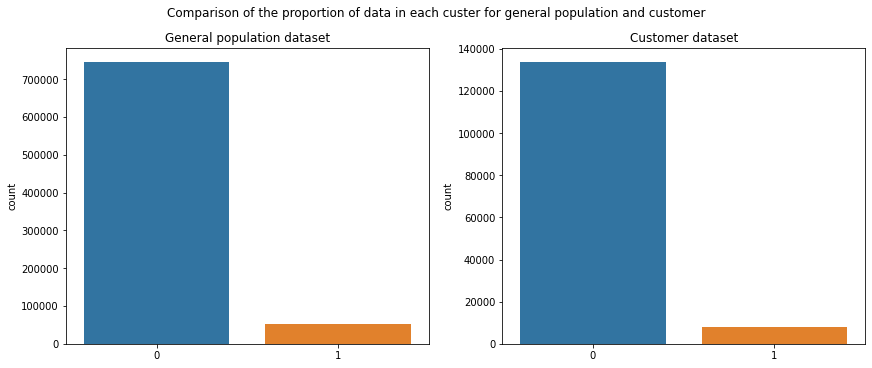

In [75]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, axes = plt.subplots(1, 2, figsize=(12,5),constrained_layout=True)
fig.suptitle('Comparison of the proportion of data in each custer for general population and customer')
axes[0].set_title('General population dataset')
axes[1].set_title('Customer dataset')
sns.countplot(kmean_fit,ax= axes[0])
sns.countplot(customer_kmean_fit,ax= axes[1])
plt.show()

Person-level features below are to be compared between the general population data and customer data

In [76]:
# Create a list of the components selected

selected_components_list = ['ANREDE_KZ', 'CJT_GESAMTTYP','FINANZTYP','LP_LEBENSPHASE_GROB','LP_FAMILIE_FEIN','NATIONALITAET_KZ','MOVEMENT','GENERATIONS']

In [77]:
# Get the column index position from the final features list

select_components_index = [final_features.index(val) for val in selected_components_list if val in final_features]

print(select_components_index)

[74, 7, 15, 36, 33, 41, 76, 77]


In [78]:
# Get original general population data with reduced components using inverse_transform.

# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

inverse_pca_general = pca.inverse_transform(general_pca)
original_inverse_general = scaler.inverse_transform(inverse_pca_general)
original_inverse_general= pd.DataFrame(original_inverse_general[:,select_components_index], columns=selected_components_list).round(decimals=0)

original_inverse_general.head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,NATIONALITAET_KZ,MOVEMENT,GENERATIONS
0,2.0,5.0,1.0,6.0,6.0,1.0,1.0,6.0
1,2.0,3.0,1.0,1.0,1.0,1.0,0.0,5.0
2,2.0,2.0,6.0,1.0,-2.0,1.0,1.0,4.0
3,1.0,5.0,4.0,10.0,10.0,1.0,1.0,4.0
4,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0


In [79]:
# Get original customer data with reduced components using inverse_transform.

inverse_pca_customer = pca.inverse_transform(customers_pca)
inverse_pca_customer = scaler.inverse_transform(inverse_pca_customer)
original_reversed_customer= pd.DataFrame(inverse_pca_customer[:,select_components_index], columns = selected_components_list).round(decimals=0)

original_reversed_customer.head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,NATIONALITAET_KZ,MOVEMENT,GENERATIONS
0,1.0,5.0,3.0,5.0,3.0,1.0,-0.0,2.0
1,2.0,2.0,2.0,3.0,1.0,1.0,-0.0,2.0
2,1.0,2.0,6.0,1.0,-2.0,1.0,1.0,2.0
3,1.0,6.0,2.0,10.0,10.0,1.0,1.0,4.0
4,1.0,4.0,5.0,5.0,3.0,1.0,-0.0,2.0


In [80]:
# Compare function to plot fields from general vs customer side by side

def compare_plot(dfg,dfc,plot_feature):
    """
    Plot same feature but for different subsets
    
    INPUT: 
    Dataframe 1, Dataframe 2, and the feature name
    
    OUTPUT:
    None
    """
    fig, axes = plt.subplots(1, 2, figsize=(12,5),constrained_layout=True)
    fig.suptitle('General population vs Customer data for {}'.format(plot_feature))
    axes[0].set_title('General cluster components reduced')
    axes[1].set_title('Customer cluster components reduced')
    sns.countplot(dfg[plot_feature],ax= axes[0])
    sns.countplot(dfc[plot_feature],ax= axes[1])
    plt.show()

### ANREDE_KZ

Gender:

* -1,0: unknown
* 1: male
* 2: female

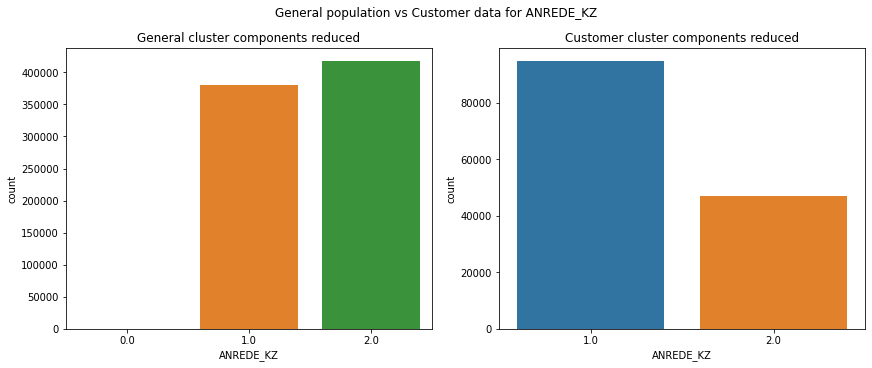

In [81]:
# People that are of gender female are over represented in the general population data and under represented in the 
# customer data

compare_plot(original_inverse_general,original_reversed_customer,selected_components_list[0])

### CJT_GESAMTTYP

Customer-Journey-Typology relating to the preferred information and buying channels of consumers

* 0: unknown
* 1: Advertising- and Consumptionminimalist
* 2: Advertising- and Consumptiontraditionalist
* 3: Advertisinginterested Store-shopper
* 4: Advertisinginterested Online-shopper
* 5: Advertising- and Cross-Channel-Enthusiast
* 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour

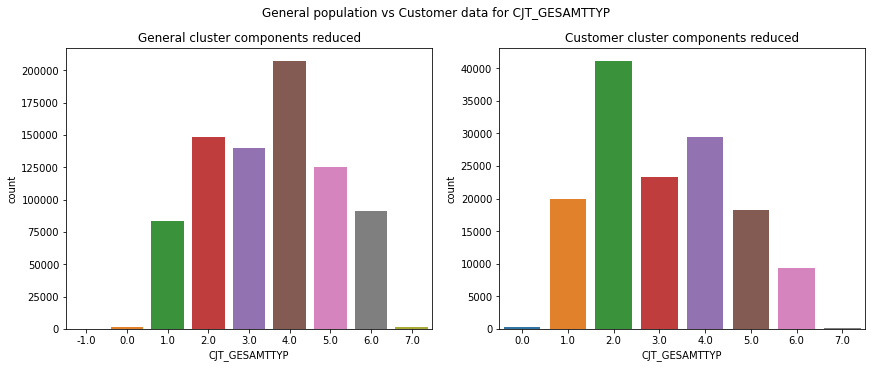

In [82]:
compare_plot(original_inverse_general,original_reversed_customer,selected_components_list[1])

### FINANZTYP

Best descirbing financial type for the peron

* -1: unknown
* 1: low finacial interest
* 2: money saver
* 3: main focus is the own house
* 4: be prepared
* 5: Investor
* 6: unremarkable

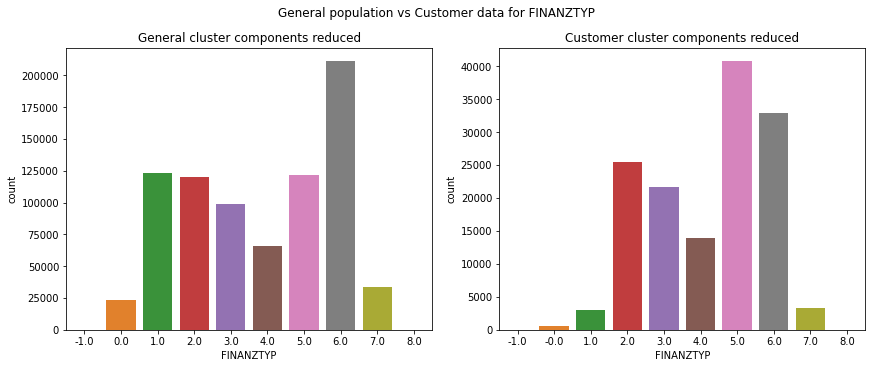

In [83]:
compare_plot(original_inverse_general,original_reversed_customer,selected_components_list[2])

### LP_LEBENSPHASE_GROB

Lifestage rough

* 1: single low-income- and average earners of younger age 
* 2: single low-income- and average earners of higher age 
* 3: single high-income earners
* 4: single low-income- and average earner-couples 
* 5: single high-income earner-couples
* 6: single parents
* 7: single low-income- and average earner-families
* 8: high-income earner-families
* 9: average earners of younger age from mulitperson households
* 10: low-income- and average earners of higher age from mulitperson households
* 11: high-income earners of younger age from multiperson households
* 12: high-income earners of higher age from multiperson households

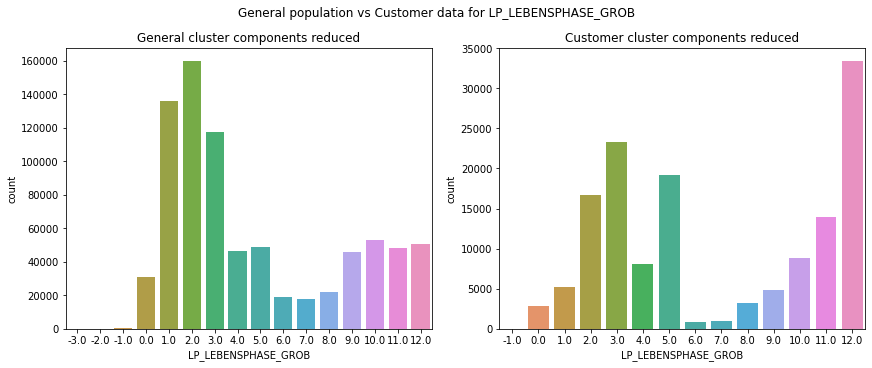

In [84]:
compare_plot(original_inverse_general,original_reversed_customer,selected_components_list[3])

### LP_FAMILIE_FEIN

familytyp fine

* 1: single 
* 2: couple
* 3: young single parent 
* 4: single parent with teenager
* 5: single parent with child of full age
* 6: young family 
* 7: family with teenager 
* 8: family with child of full age
* 9: shared flat
* 10: two-generational household
* 11:multi-generational household

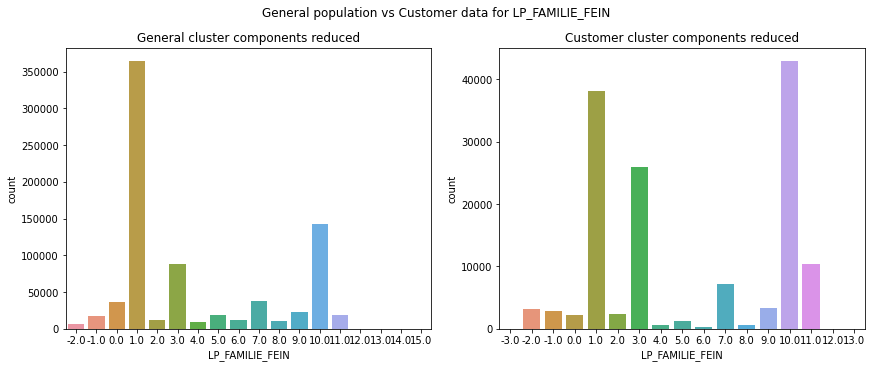

In [85]:
compare_plot(original_inverse_general,original_reversed_customer,selected_components_list[4])

### NATIONALITAET_KZ

Nationaltity (scored by prename analysis)

* -1, 0: unknown
* 1: sounding german
* 2: sounding foreign
* 3: assimilated names

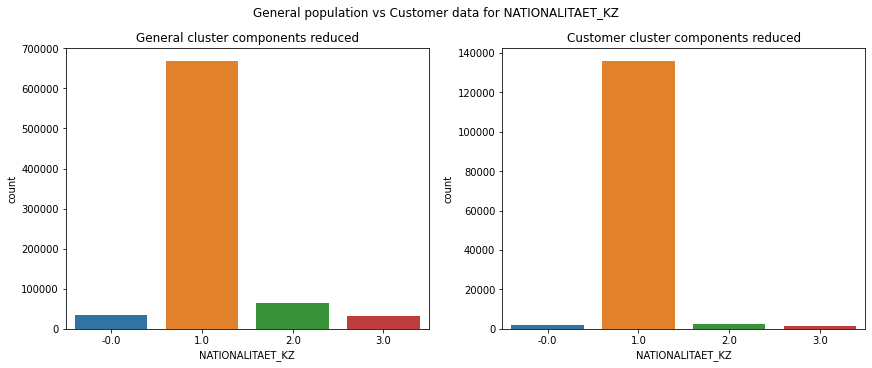

In [86]:
compare_plot(original_inverse_general,original_reversed_customer,selected_components_list[5])

### PRAEGENDE_JUGENDJAHRE - MOVEMENT

Dominating movement in the person's youth (avantgarde or mainstream)

* -1, 0: unknown
* 1: 40ies - war years (Mainstream, O+W)
* 2: 40ies - reconstruction years (Avantgarde, O+W)
* 3: 50ies - economic miracle (Mainstream, O+W)
* 4: 50ies - milk bar / Individualisation (Avantgarde, O+W)
* 5: 60ies - economic miracle (Mainstream, O+W)
* 6: 60ies - generation 68 / student protestors (Avantgarde, W)
* 7: 60ies - opponents to the building of the Wall (Avantgarde, O)
* 8: 70ies - family orientation (Mainstream, O+W)
* 9: 70ies - peace movement (Avantgarde, O+W)
* 10: 80ies - Generation Golf (Mainstream, W)
* 11: 80ies - ecological awareness (Avantgarde, W)
* 12: 80ies - FDJ / communist party youth organisation (Mainstream, O)
* 13: 80ies - Swords into ploughshares (Avantgarde, O)
* 14: 90ies - digital media kids (Mainstream, O+W)
* 15: 90ies - ecological awareness (Avantgarde, O+W)

Engineered MOVEMENT

* 0: Avantgarde
* 1: Mainstream


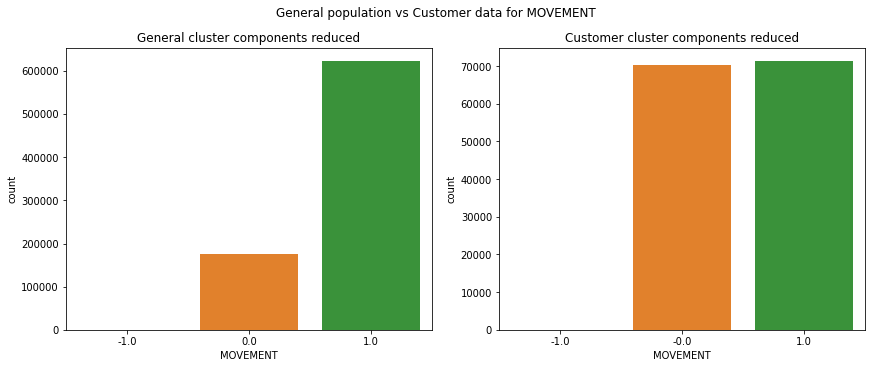

In [87]:
compare_plot(original_inverse_general,original_reversed_customer,selected_components_list[6])

### PRAEGENDE_JUGENDJAHRE - GENERATIONS

Dominating movement in the person's youth (avantgarde or mainstream)

* -1, 0: unknown
* 1: 40ies - war years (Mainstream, O+W)
* 2: 40ies - reconstruction years (Avantgarde, O+W)
* 3: 50ies - economic miracle (Mainstream, O+W)
* 4: 50ies - milk bar / Individualisation (Avantgarde, O+W)
* 5: 60ies - economic miracle (Mainstream, O+W)
* 6: 60ies - generation 68 / student protestors (Avantgarde, W)
* 7: 60ies - opponents to the building of the Wall (Avantgarde, O)
* 8: 70ies - family orientation (Mainstream, O+W)
* 9: 70ies - peace movement (Avantgarde, O+W)
* 10: 80ies - Generation Golf (Mainstream, W)
* 11: 80ies - ecological awareness (Avantgarde, W)
* 12: 80ies - FDJ / communist party youth organisation (Mainstream, O)
* 13: 80ies - Swords into ploughshares (Avantgarde, O)
* 14: 90ies - digital media kids (Mainstream, O+W)
* 15: 90ies - ecological awareness (Avantgarde, O+W)

Engineered GENERATIONS

* 1: 40s
* 2: 50s
* 3: 60s
* 4: 70s
* 5: 80s
* 6: 90s

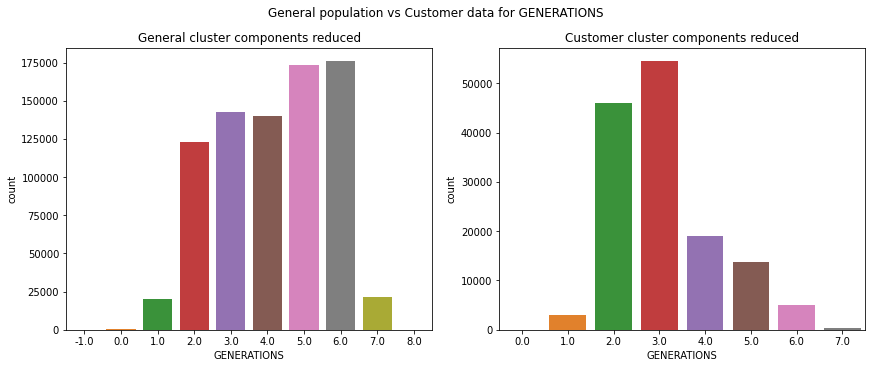

In [88]:
compare_plot(original_inverse_general,original_reversed_customer,selected_components_list[7])

People overrepresented in customer data compared to general population data

* Male
* Advertising- and Consumptiontraditionalist
* Investor
* High-income earners of higher age from multiperson households
* Young single parent, two-generational household, and multi-generational household
* Sounding german
* Avantgarde
* 50s and 60s

People underrepresented in customer data compared to the general population data

* Female
* Advertisinginterested Online-shopper
* low finacial interest
* single low-income- and average earners of younger age and single low-income- and average earners of higher age
* sounding foreign
* 70s, 80s, and 90s


#### Discussion:

Base on the comparision, the population segment popular with the mail-order sales company are male, single or young single parents from two-generational or multi-generational households in their 50s or 60s who are high-income earners or investors and native German speaker.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Supervised Learning Model - Step 1: Load attributes provided in attributes information spreadsheet

There are attributes in the dataset with no information provided in the attribute information spreadsheet. The attributes used in this supervised learning model is focused on those contained in this spreadsheet.

In [89]:
# Load attributes from information spreadsheet
data_attributes = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx')

In [90]:
# Create a list of attributes
data_attributes_list = list(data_attributes.Attribute)

In [91]:
#There are space separated values in the list, this function is used to split and join them using comma.
def splitjoinattr(attr_list):
    """
    Get a proper comma separated list from a
    list containing space seperated values.
    
    INPUT:
    A list.
    
    OUTPUT:
    Return list of values separated by comma"""
    sep_attr_list = []
    for item in attr_list:
        split_attr = item.split()
        sep_attr_list.extend(split_attr)
    return sep_attr_list

In [92]:
# Split and join attributes

data_attributes_list = splitjoinattr(data_attributes_list)

In [93]:
# Rename column to match what is provided in the dataset

data_attributes_list[data_attributes_list.index('CAMEO_DEUINTL_2015')] = 'CAMEO_INTL_2015'

In [94]:
# Number of attribute

len(data_attributes_list)

326

### Supervised Learning Model - Step 2: Load and Prepare Test and Train data

The mailout_train and mailout_test data are loaded and only attributes contained in the information spreadsheet retained. The dataset is then cleaned using the clean_data function.

In [95]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [96]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [97]:
cols_to_keep = list(set(list(mailout_test.columns)).intersection(set(data_attributes_list)))

In [98]:
mailout_test = mailout_test[cols_to_keep]

In [99]:
clean_mailout_test = clean_data(mailout_test)

In [100]:
cols_to_keep = list(set(list(mailout_train.columns)).intersection(set(data_attributes_list))) + ['RESPONSE']

In [101]:
mailout_train = mailout_train[cols_to_keep]

In [102]:
clean_mailout_train = clean_data(mailout_train)

### Supervised Learning Model - Step 3: Split and Normalize mailout_train Data

The strategy here is to first normalize already cleaned mailout_data in step 2 above. The normalized data is then split into train and validate dataset using StratifiedShuffleSplit. This is to ensure that class distribution is maintained in both the training and validation dataset thereby reducing bias and overfitting.

In [103]:
def normalize_df(df):
    """
    Fill NaN, scale and normalize dataset.
    
    INPUT: df
    
    OUTPUT:
    Normalized df"""
    cleaned_df_features = list(df.columns)
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'median').fit(df)
    transform_imputer = imputer.transform(df)
    df_imputer = pd.DataFrame(transform_imputer, columns = cleaned_df_features)
    scaler = RobustScaler().fit(df_imputer)
    imputer_normalize = scaler.transform(df_imputer)
    df = pd.DataFrame(imputer_normalize,columns = cleaned_df_features)
    return(df)

In [104]:
# Create y_train and x_train datasets

mailout_y_train = clean_mailout_train['RESPONSE']
mailout_x_train = clean_mailout_train.drop('RESPONSE',axis=1)

In [105]:
# Split the training data into train and validation

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.33, random_state=42)

for train_index, test_index in sss.split(mailout_x_train,mailout_y_train):
    x_train, x_val = mailout_x_train.iloc[train_index], mailout_x_train.iloc[test_index]
    y_train, y_val = mailout_y_train.iloc[train_index], mailout_y_train.iloc[test_index]

In [106]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(22923, 262)
(22923,)
(11291, 262)
(11291,)


In [107]:
train_normalize = normalize_df(x_train)

In [108]:
val_normalize = normalize_df(x_val)

### Supervised Learning Model - Step 4: Train and Validate mainout_train data

The mailout_data split in step 3 is trained and validated against 5 different supervised learning model classifiers below. Then the accuracy score for each classifier shown. This is without setting hyperparameters. The accuracy score was favored because the use of StratifiedShuffleSplit() ensures balanced classes in such a way that class distribution is maintained in the training and test set. In this case accuracy would provide a good overall assessment of the performance of the models.

In [110]:
clf = [
        LogisticRegression(random_state=42,solver='liblinear',n_jobs=-1),
        DecisionTreeClassifier(random_state=42),
        SVC(random_state=42),
        RandomForestClassifier(random_state=42,n_jobs=-1),
        AdaBoostClassifier(random_state=42)
        ]


models = ['LogisticRegression','DecisionTreeClassifier','SVC','RandomForestClassifier','AdaBoostClassifier']

In [112]:
clf_accuracy = []
clf_precision = []

In [113]:
for model in clf:
    model.fit(train_normalize,y_train)
    y_pred = model.predict(val_normalize)
    clf_accuracy.append(accuracy_score(y_val,y_pred))
    fpr,tpr,d_threshold = roc_curve(y_val,y_pred)
    clf_precision.append(precision_score(y_val,y_pred))

In [115]:
accuracy_df = pd.DataFrame({'clf':models,'accuracy':clf_accuracy,'precision':clf_precision}) 
accuracy_df

,clf,accuracy,precision
0,LogisticRegression,0.987601,0.000000
1,DecisionTreeClassifier,0.968648,0.009174
2,SVC,0.987601,0.000000
3,RandomForestClassifier,0.987601,0.000000
4,AdaBoostClassifier,0.987601,0.000000


### Supervised Learning Model - Step 5: Parameter Tuning and GridSearchCV

Step 4 above is repeated with GridSearchCV and hyperparameters tuning. Using accuracy evaluation metric, the DecisionTreeClassifier was selected even though the accuracy score is lower than the reset of the classifers to reduce overfitting.This classifier and the hyperparameters with the best score is used to train using the training data and predict using the test data.

In [118]:
param_grid = {
    models[0]:{'solver': ['lbfgs', 'liblinear']},
    models[1]:{'criterion': ['gini'],'max_depth': [5, 10, 15],'min_samples_split': [2]},
    models[2]:{'gamma': ['scale']},
    models[3]:{'n_estimators': [10, 20, 30, 40, 45]},
    models[4]:{'n_estimators': [10, 20, 30, 40, 45], 'learning_rate': [0.01, 0.1]}
}


In [119]:
for model, sm_classifer in zip(models,clf):
    grid_search = GridSearchCV(sm_classifer, param_grid[model], scoring='accuracy',n_jobs=1)
    grid_search.fit(train_normalize, y_train)
    best_params = grid_search.best_params_
    best_scores = grid_search.best_score_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(val_normalize)
    model_accuracy = accuracy_score(y_val,y_pred)
    model_precision = precision_score(y_val,y_pred)
    best_index = grid_search.best_index_
    std_test_score = grid_search.cv_results_['std_test_score'][best_index]
    print('Classifier: ', model)
    print('Best parameter: ', best_params)
    print('Best Score', best_scores)
    print('Model Accuracy: ', model_accuracy)
    print('Model Precision : ', model_precision)
    print('Model Standard Deviation of Validation Score: ', std_test_score, '\n')

Classifier:  LogisticRegression
Best parameter:  {'solver': 'lbfgs'}
Best Score 0.9876107022482067
Model Accuracy:  0.9876007439553627
Model Precision :  0.0
Model Standard Deviation of Validation Score:  8.645281348678032e-05 

Classifier:  DecisionTreeClassifier
Best parameter:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Best Score 0.9869999295829597
Model Accuracy:  0.9871579133823399
Model Precision :  0.0
Model Standard Deviation of Validation Score:  0.00047059853757215126 

Classifier:  SVC
Best parameter:  {'gamma': 'scale'}
Best Score 0.9876107022482067
Model Accuracy:  0.9876007439553627
Model Precision :  0.0
Model Standard Deviation of Validation Score:  8.645281348678032e-05 

Classifier:  RandomForestClassifier
Best parameter:  {'n_estimators': 10}
Best Score 0.9876107022482067
Model Accuracy:  0.9876007439553627
Model Precision :  0.0
Model Standard Deviation of Validation Score:  8.645281348678032e-05 

Classifier:  AdaBoostClassifier
Best parameter: 

In [120]:
mailout_x_train_normalized = normalize_df(mailout_x_train)

In [121]:
mailout_test_normalized = normalize_df(clean_mailout_test)

In [122]:
decision_tree_classifier = DecisionTreeClassifier(criterion='gini',max_depth=20,random_state=42)
decision_tree_classifier.fit(mailout_x_train_normalized, mailout_y_train)

# Predict using the trained model
y_pred = decision_tree_classifier.predict(mailout_test_normalized)

In [123]:
# prediction count

print(np.unique(y_pred, return_counts=True))

(array([0, 1]), array([33505,   672]))
